# IMPORT LIBRARIES

In [79]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score # root_mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

# GET DATA

In [4]:
games = pd.read_csv("../data/games_normalized_clean.csv")

# Models

In [6]:
games_labels = games["Estimated owners"]
games = games.drop("Estimated owners", axis = 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(games, games_labels, test_size = 0.2, random_state= 42)

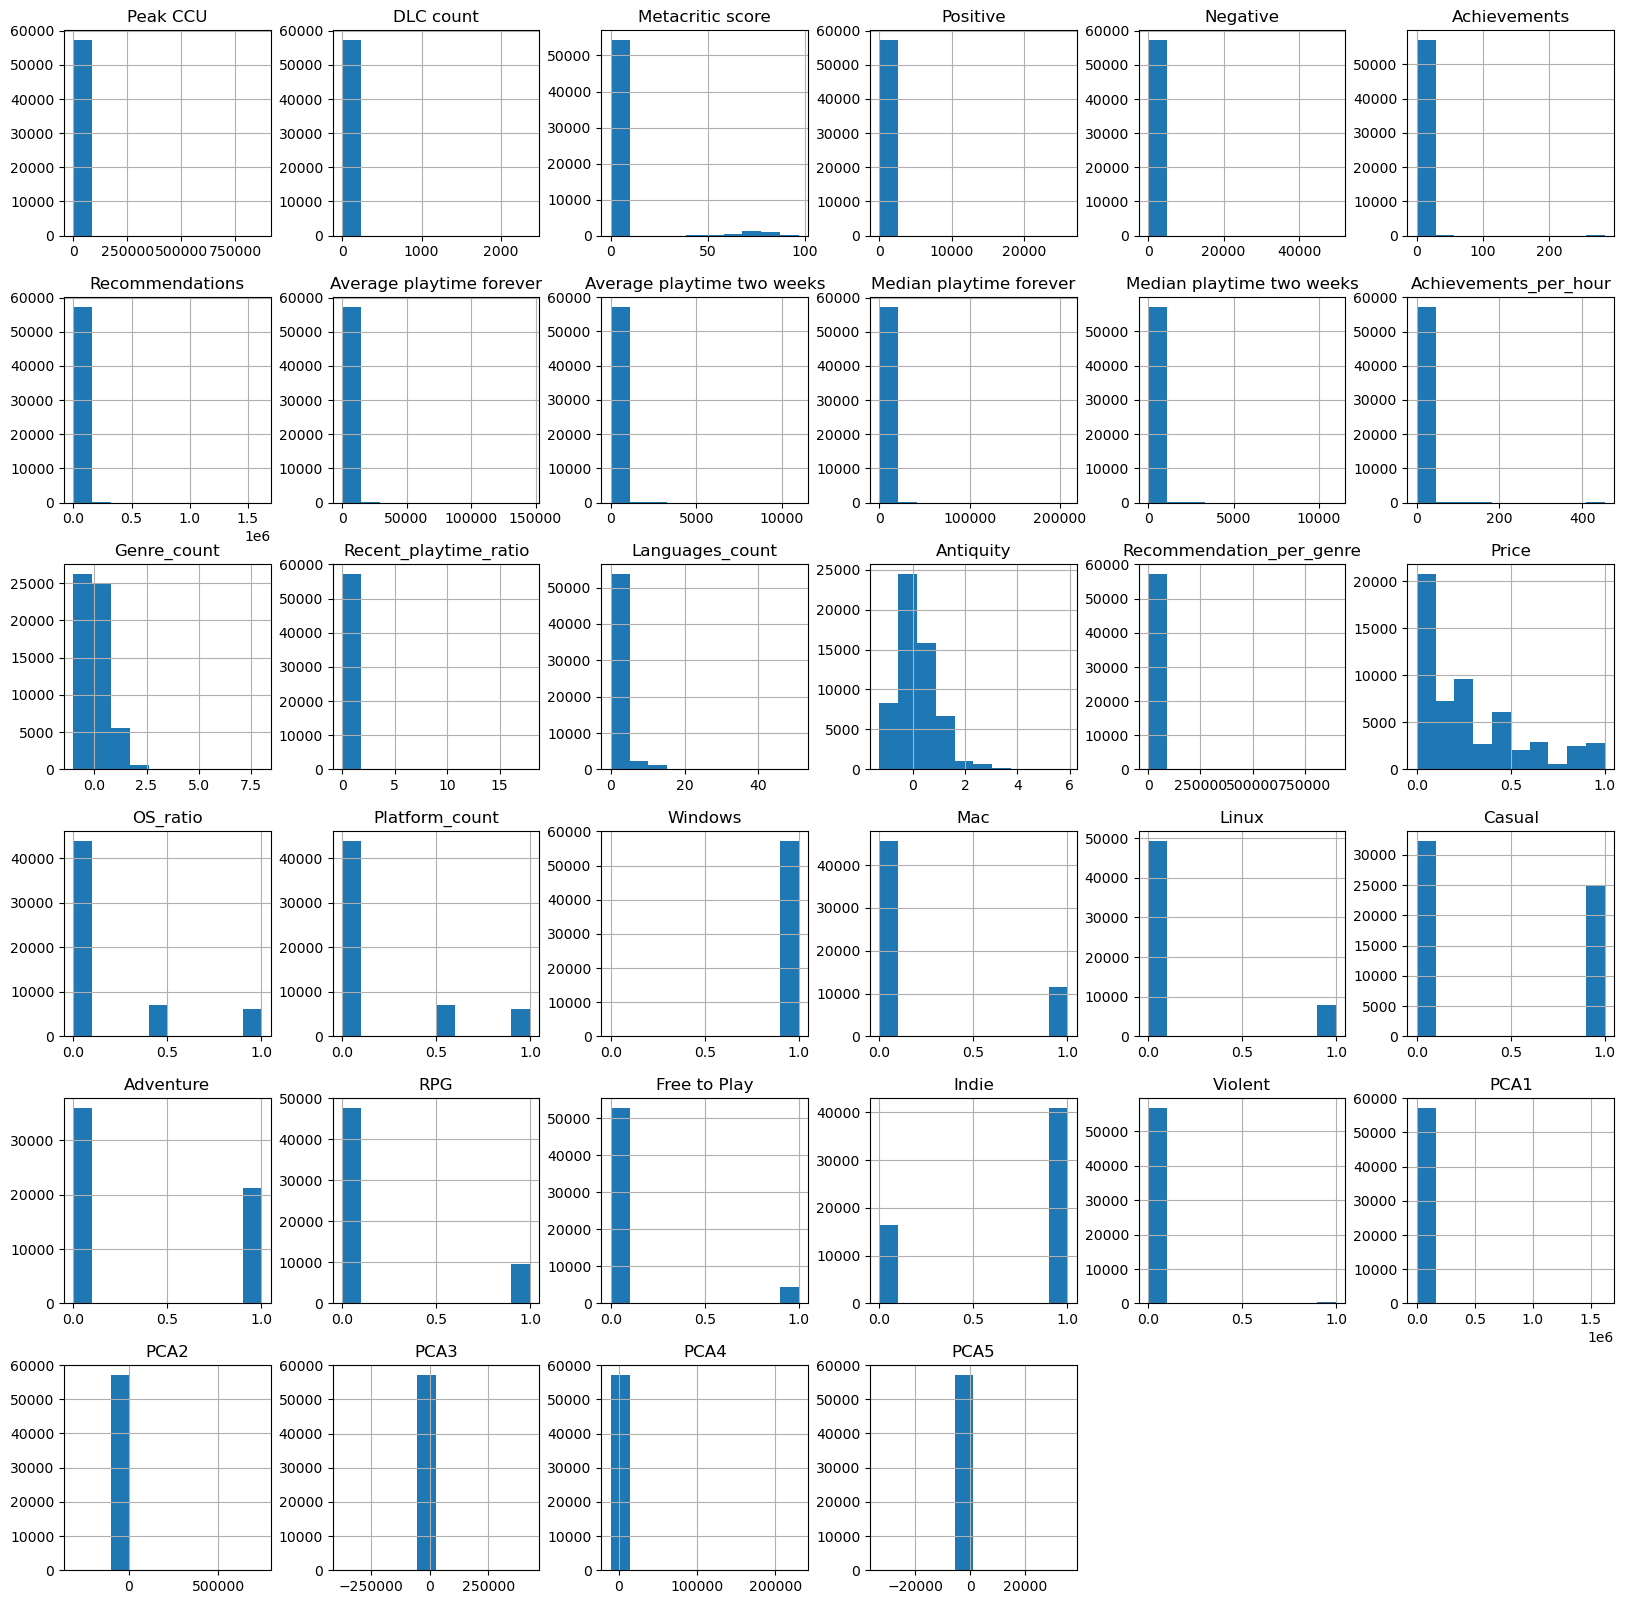

In [8]:
X_train.hist(figsize = (20, 20))
plt.show()

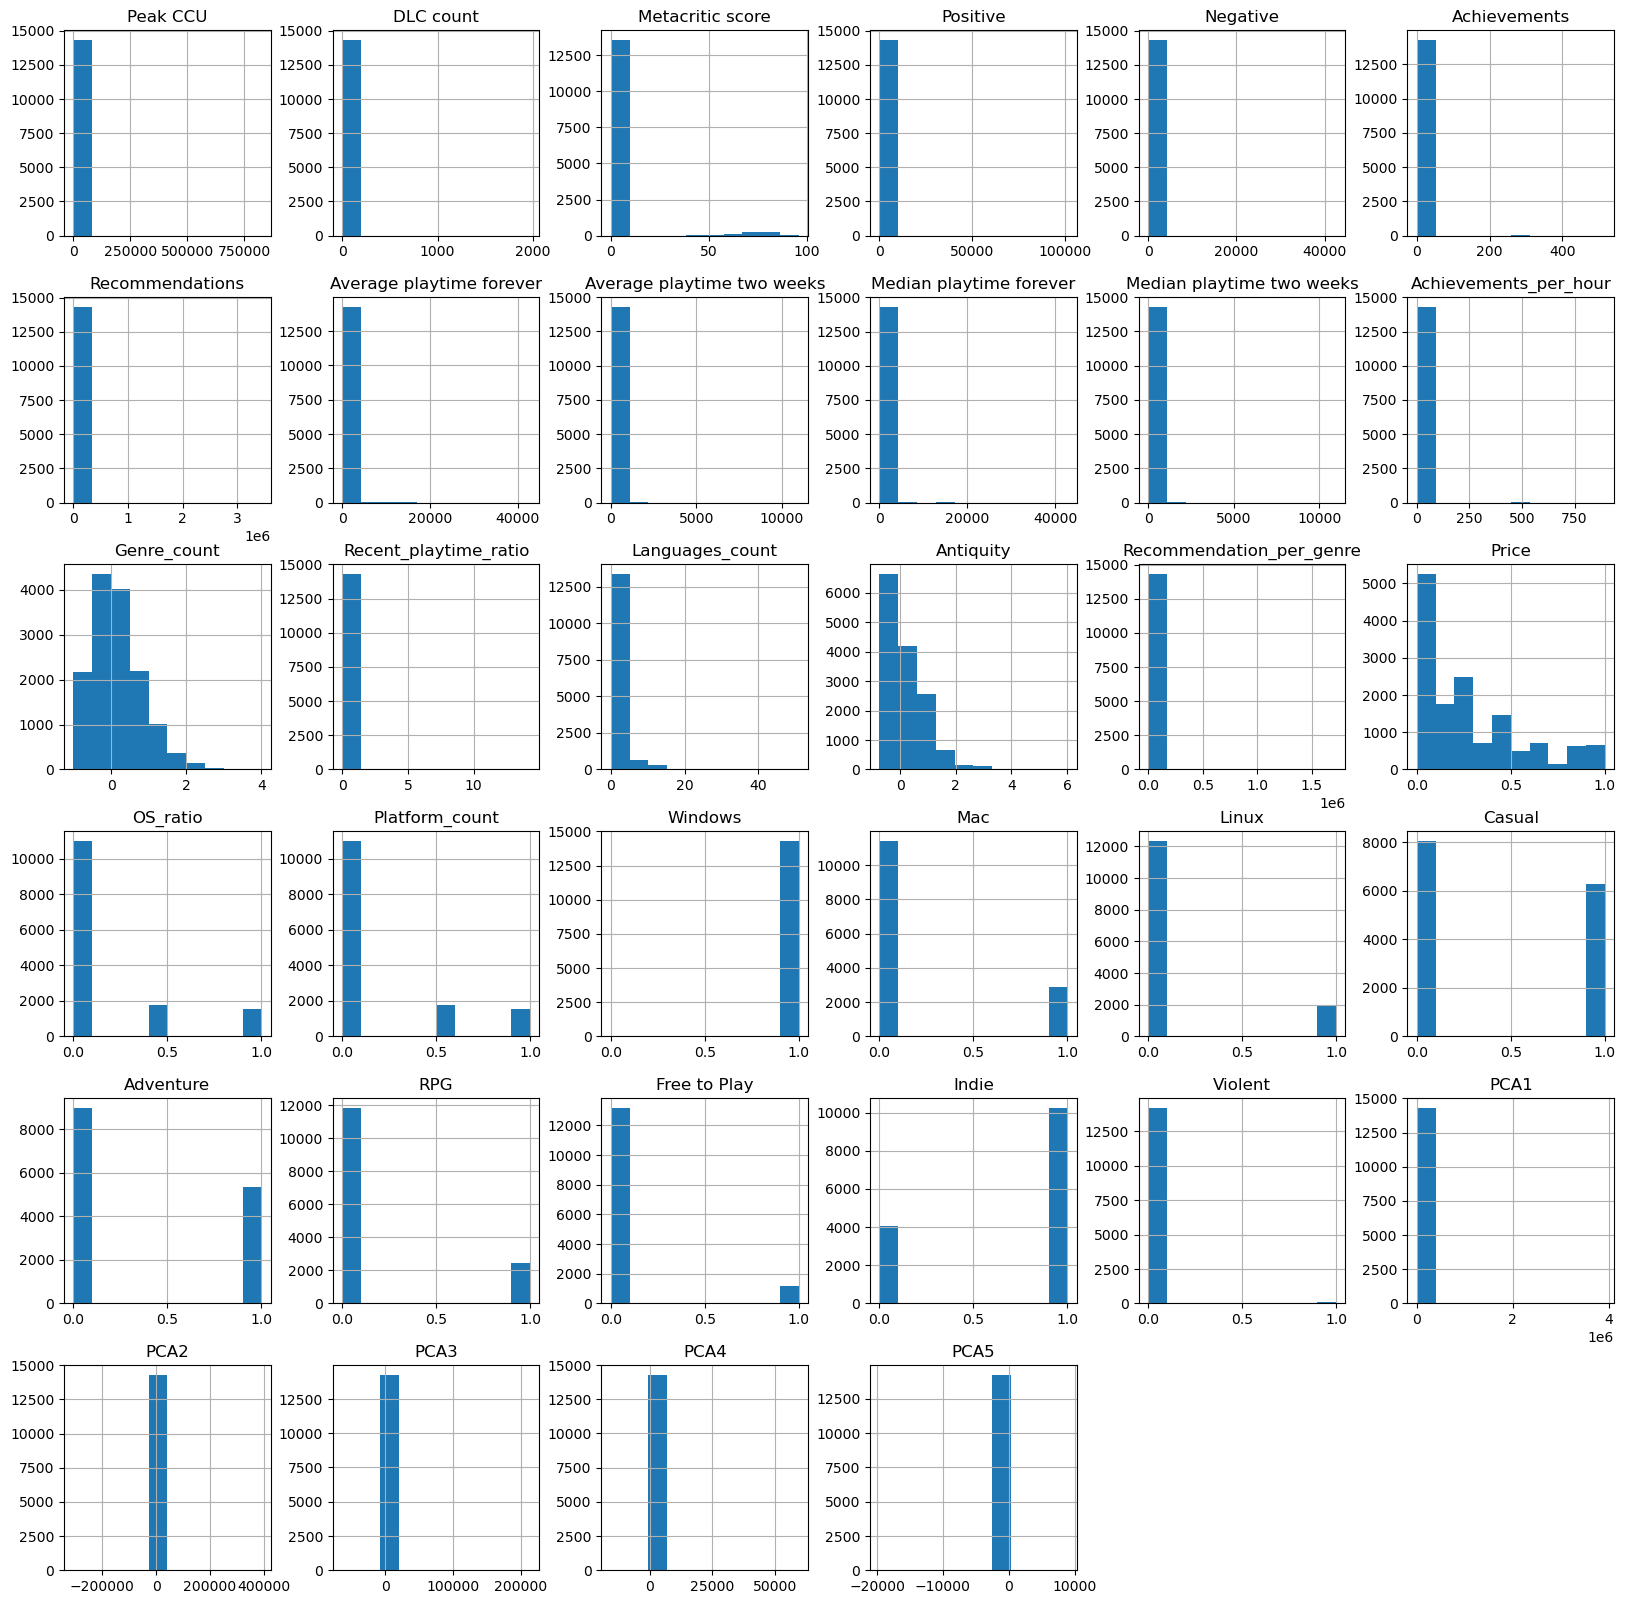

In [9]:
X_test.hist(figsize = (20, 20))
plt.show()

# Models

In [49]:
# Inicialización y entrenamiento del modelo HistGradientBoostingClassifier
model = HistGradientBoostingClassifier(max_iter = 100, max_depth = 100, random_state=42)
model.fit(X_train, y_train)

HistGradientBoostingClassifier(max_depth=100, random_state=42)

In [50]:
y_predict = model.predict(X_test)

In [51]:
accuracy_score(y_test, y_predict)

0.6611495216146379

In [75]:
model = CatBoostClassifier(iterations=1000, 
                           depth= 10, 
                           learning_rate=0.1, 
                           loss_function='MultiClass', 
                           cat_features=[],
                           random_seed=42,
                           verbose=100)

In [76]:
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

0:	learn: 1.2708429	total: 241ms	remaining: 4m
100:	learn: 0.6374149	total: 35s	remaining: 5m 11s
200:	learn: 0.5767463	total: 1m 8s	remaining: 4m 31s
300:	learn: 0.5279396	total: 1m 41s	remaining: 3m 56s
400:	learn: 0.4857458	total: 2m 15s	remaining: 3m 21s
500:	learn: 0.4529652	total: 2m 48s	remaining: 2m 47s
600:	learn: 0.4242904	total: 3m 21s	remaining: 2m 14s
700:	learn: 0.3981516	total: 3m 55s	remaining: 1m 40s
800:	learn: 0.3756271	total: 4m 29s	remaining: 1m 6s
900:	learn: 0.3552434	total: 5m 3s	remaining: 33.3s
999:	learn: 0.3365368	total: 5m 36s	remaining: 0us


In [77]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6354494028912634

In [80]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.callbacks import DeadlineStopper, DeltaXStopper

In [84]:
model = HistGradientBoostingClassifier()

# Espacio de hiperparámetros para la búsqueda de Hyperband
param_space = {
    'learning_rate': Real(0.01, 0.1),
    'max_iter': Integer(50, 500),
    'max_depth': Integer(3, 15),
    # 'min_samples_leaf': Integer(1, 20),
    # 'l2_regularization': Real(1e-10, 1.0, prior="log-uniform")
}

# Configurar BayesSearchCV con Hyperband
bayes_search = BayesSearchCV(
    estimator = model,
    search_spaces = param_space,
    n_iter = 32,  # Puedes ajustar el número de iteraciones
    scoring = 'accuracy',
    cv = 5,  # Validación cruzada
    n_jobs = -1,
    verbose = 0,
    random_state = 42,
    optimizer_kwargs = {'base_estimator': 'GP'}  # Usar proceso gaussiano
)

# Ajustar el modelo
bayes_search.fit(X_train, y_train)

# Mejor resultado
print("Best score:", bayes_search.best_score_)
print("Best parameters:", bayes_search.best_params_)

# Evaluar en el conjunto de prueba
accuracy = bayes_search.score(X_test, y_test)
print("Test accuracy:", accuracy)

Best score: 0.6563651726066204
Best parameters: OrderedDict([('learning_rate', 0.05860476197204285), ('max_depth', 3), ('max_iter', 446)])
Test accuracy: 0.6631748027096864


In [88]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Definir un clasificador base para AdaBoost
base_estimator = DecisionTreeClassifier(max_depth = 10)

# Crear el clasificador AdaBoost
adaboost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)

# Aplicar Bagging al clasificador AdaBoost
bagging_adaboost = BaggingClassifier(
    base_estimator = adaboost,
    n_estimators = 20,          # Número de modelos AdaBoost en el conjunto
    random_state = 42,
    n_jobs = 4                  # Usar todos los núcleos para paralelización
)

# Entrenar el modelo Bagging con AdaBoost
bagging_adaboost.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = bagging_adaboost.predict(X_test)

# Calcular precisión
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6390809414065228


In [89]:
from PSO import particle_swarm_optimization

In [ ]:
def objective_function(hyperparameters):
    n_estimators, max_depth = int(hyperparameters[0]), int(hyperparameters[1])
    
    model = RandomForestClassifier(
        n_estimators = n_estimators, 
        max_depth = max_depth, 
        random_state = 42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Minimizar la función (por eso la negamos)

# Parámetros de PSO
bounds = [(10, 200), (1, 20)]  # Ejemplo de rango de búsqueda para n_estimators y max_depth
dim = 2  # Dos hiperparámetros a optimizar

In [91]:
best_hyperparameters, best_score = particle_swarm_optimization(objective_function, bounds, dim)
print("Mejores hiperparámetros:", best_hyperparameters)
print("Mejor precisión obtenida:", best_score)

Iteración 1/10, Mejor precisión: 0.6591242405195894
Iteración 2/10, Mejor precisión: 0.6597527760318458
Iteración 3/10, Mejor precisión: 0.6597527760318458
Iteración 4/10, Mejor precisión: 0.6597527760318458
Iteración 5/10, Mejor precisión: 0.6603813115441023
Iteración 6/10, Mejor precisión: 0.6603813115441023
Iteración 7/10, Mejor precisión: 0.6603813115441023
Iteración 8/10, Mejor precisión: 0.6603813115441023
Iteración 9/10, Mejor precisión: 0.6603813115441023
Iteración 10/10, Mejor precisión: 0.6603813115441023
Mejores hiperparámetros: [78.21379753 14.34870536]
Mejor precisión obtenida: 0.6603813115441023


In [94]:
import optuna

In [97]:
def objective(trial):
    # Definir los hiperparámetros para el RandomForestClassifier usando la API de Optuna
    max_iter = trial.suggest_int('max_iter', 100, 500)  # Número de iteraciones
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)  # Tasa de aprendizaje
    max_depth = trial.suggest_int('max_depth', 3, 15)  # Profundidad máxima
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)  # Mínimo de muestras por hoja
    max_bins = trial.suggest_int('max_bins', 8, 64)  # Número máximo de bins (para manejo de datos continuos)

    # Crear el modelo con los parámetros dados
    model = HistGradientBoostingClassifier(
        max_iter=max_iter,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_bins=max_bins,
        random_state=42
    )
    
    # Evaluar el modelo usando validación cruzada
    score = cross_val_score(model, games, games_labels, cv=5, scoring='accuracy')
    
    # Optuna maximiza la función objetivo, así que devolvemos la media de las precisiones
    return np.mean(score)  # Retorna la precisión media, que será maximizada

# Crear un estudio de Optuna
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())

# Realizar la optimización
study.optimize(objective, n_trials=50)  # Puedes ajustar el número de trials

# Imprimir los mejores resultados
print("Mejores hiperparámetros:", study.best_params)
print("Mejor valor de la función objetivo (precisión):", study.best_value)

[I 2024-11-12 22:08:48,308] A new study created in memory with name: no-name-dc0b57c9-ddf8-4f10-93df-6a6d791021f9


[I 2024-11-12 22:14:41,339] Trial 0 finished with value: 0.6263419271231847 and parameters: {'max_iter': 492, 'learning_rate': 0.011707553861347598, 'max_depth': 13, 'min_samples_leaf': 4, 'max_bins': 64}. Best is trial 0 with value: 0.6263419271231847.
[I 2024-11-12 22:18:22,802] Trial 1 finished with value: 0.6287165585008274 and parameters: {'max_iter': 396, 'learning_rate': 0.017500858885677165, 'max_depth': 13, 'min_samples_leaf': 3, 'max_bins': 20}. Best is trial 1 with value: 0.6287165585008274.
[I 2024-11-12 22:20:03,665] Trial 2 finished with value: 0.6234504198874953 and parameters: {'max_iter': 234, 'learning_rate': 0.04539087334421062, 'max_depth': 8, 'min_samples_leaf': 3, 'max_bins': 55}. Best is trial 1 with value: 0.6287165585008274.
[I 2024-11-12 22:21:32,936] Trial 3 finished with value: 0.6103480859147007 and parameters: {'max_iter': 327, 'learning_rate': 0.07168804643815956, 'max_depth': 3, 'min_samples_leaf': 3, 'max_bins': 42}. Best is trial 1 with value: 0.628716

Mejores hiperparámetros: {'max_iter': 224, 'learning_rate': 0.011062984363199396, 'max_depth': 6, 'min_samples_leaf': 2, 'max_bins': 22}
Mejor valor de la función objetivo (precisión): 0.6337312243782226
